# ADA Boosting Classifier

## Pull and Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('hate_speech_training.csv')
df_train_2 = pd.read_csv('hate_speech_training_2.csv')
df_train_3 = pd.read_csv('hate_speech_training_3.csv')
df_train_4 = pd.read_csv('hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('hate_speech_training_5.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## NLP Cleaning

In [11]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
sw = stopwords.words('english')
sw_add = ['@user', '#', '@', 'https', 'amp', 'co', 
          'http', 'RT', '#','##','####','######','##########','##@user']
sw = sw + sw_add

In [15]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([@#a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [17]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]
test_token_docs = [doc_preparer(doc, sw) for doc in X_test]

## TF-IDF on an ADA Boosting Model with Classes Balanced

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [21]:
tfidf_ada_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('ada', AdaBoostClassifier())
])

In [30]:
tfidf_ada_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('ada', AdaBoostClassifier())])

In [31]:
tfidf_ada_pipe.score(X_train, y_train)

0.8736226954460748

In [17]:
from sklearn.model_selection import cross_val_score

In [33]:
cross_val_score(tfidf_ada_pipe, X_train, y_train, cv = 8)

array([0.86264293, 0.87697207, 0.86466927, 0.87002461, 0.86799826,
       0.8572876 , 0.86785352, 0.87405906])

In [18]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

In [35]:
tfidf_ada_pipe.score(X_test, y_test)

0.877478651034882

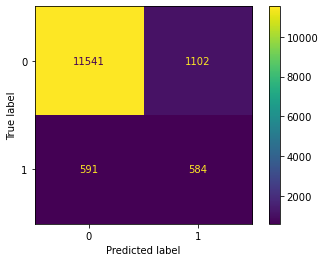

In [36]:
plot_confusion_matrix(tfidf_ada_pipe, X_test, y_test)

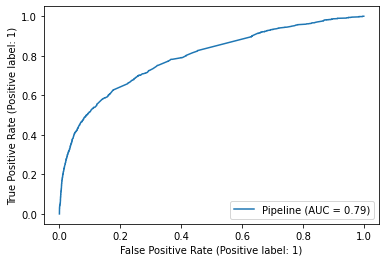

In [37]:
plot_roc_curve(tfidf_ada_pipe, X_test, y_test)

In [38]:
y_hat = tfidf_ada_pipe.predict(X_test)
print(classification_report(y_pred = y_hat, y_true = y_test))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     12643
           1       0.35      0.50      0.41      1175

    accuracy                           0.88     13818
   macro avg       0.65      0.70      0.67     13818
weighted avg       0.90      0.88      0.89     13818



## TF-IDF on an ADA Boosting Model with Minority Class 75% Balanced

In [35]:
tfidf_75_ada_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('ada', AdaBoostClassifier())
])

In [28]:
tfidf_75_ada_pipe.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('ada', AdaBoostClassifier())])

In [29]:
tfidf_75_ada_pipe.score(token_docs, y_train)

0.8794123500569919

In [30]:
tfidf_75_ada_pipe.score(test_token_docs, y_test)

0.8833405702706615

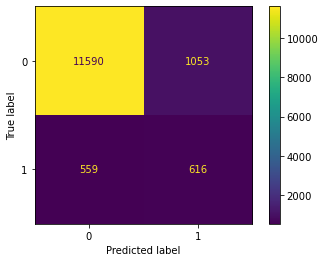

In [31]:
plot_confusion_matrix(tfidf_75_ada_pipe, test_token_docs, y_test)

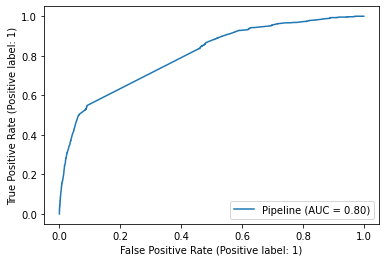

In [32]:
plot_roc_curve(tfidf_75_ada_pipe, test_token_docs, y_test)

In [34]:
y_hat_2 = tfidf_75_ada_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_2, y_true = y_test))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93     12643
           1       0.37      0.52      0.43      1175

    accuracy                           0.88     13818
   macro avg       0.66      0.72      0.68     13818
weighted avg       0.90      0.88      0.89     13818



## TF-IDF on an ADA Boosting Model with Minority Class 90% Balanced

In [36]:
tfidf_90_ada_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.9)),
    ('ada', AdaBoostClassifier())
])

In [37]:
tfidf_90_ada_pipe.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('ada', AdaBoostClassifier())])

In [38]:
tfidf_90_ada_pipe.score(token_docs, y_train)

0.8869027157098659

In [39]:
tfidf_90_ada_pipe.score(test_token_docs, y_test)

0.8929656969170647

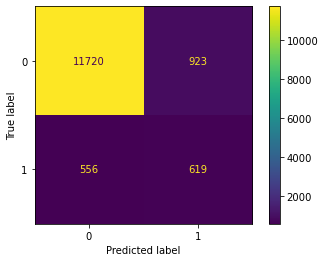

In [40]:
plot_confusion_matrix(tfidf_90_ada_pipe, test_token_docs, y_test)

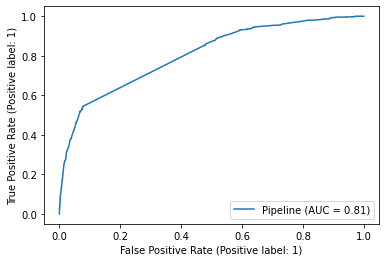

In [41]:
plot_roc_curve(tfidf_90_ada_pipe, test_token_docs, y_test)

In [42]:
y_hat_3 = tfidf_90_ada_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_3, y_true = y_test))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     12643
           1       0.40      0.53      0.46      1175

    accuracy                           0.89     13818
   macro avg       0.68      0.73      0.70     13818
weighted avg       0.91      0.89      0.90     13818



## Count Vectorizer on an ADA Boosting Model with Classes Balanced

In [50]:
cv_ada_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('ada', AdaBoostClassifier())
])

In [44]:
cv_ada_pipe.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('ada', AdaBoostClassifier())])

In [45]:
cv_ada_pipe.score(token_docs, y_train)

0.6567639449259105

In [46]:
cv_ada_pipe.score(test_token_docs, y_test)

0.654363873208858

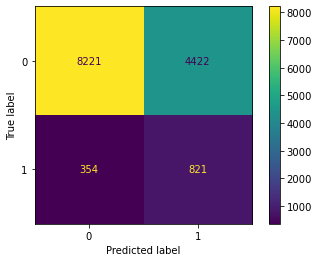

In [47]:
plot_confusion_matrix(cv_ada_pipe, test_token_docs, y_test)

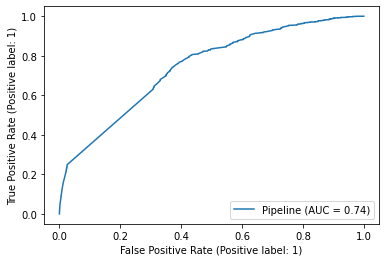

In [48]:
plot_roc_curve(cv_ada_pipe, test_token_docs, y_test)

In [49]:
y_hat_4 = cv_ada_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_4, y_true = y_test))

              precision    recall  f1-score   support

           0       0.96      0.65      0.77     12643
           1       0.16      0.70      0.26      1175

    accuracy                           0.65     13818
   macro avg       0.56      0.67      0.52     13818
weighted avg       0.89      0.65      0.73     13818



## Count Vectorizer on an ADA Boosting Model with Classes 75/25

In [51]:
cv_75_ada_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('ada', AdaBoostClassifier())
])

In [52]:
cv_75_ada_pipe.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('ada', AdaBoostClassifier())])

In [53]:
cv_75_ada_pipe.score(token_docs, y_train)

0.6859293300284055

In [54]:
cv_75_ada_pipe.score(test_token_docs, y_test)

0.6872919380518164

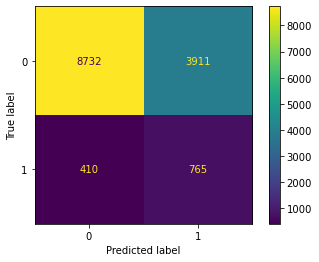

In [55]:
plot_confusion_matrix(cv_75_ada_pipe, test_token_docs, y_test)

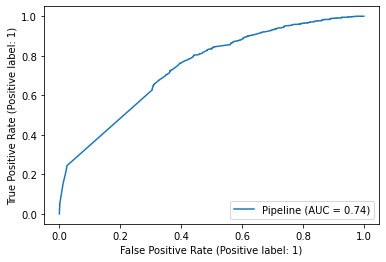

In [56]:
plot_roc_curve(cv_75_ada_pipe, test_token_docs, y_test)

In [58]:
y_hat_5 = cv_75_ada_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_5, y_true = y_test))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     12643
           1       0.16      0.65      0.26      1175

    accuracy                           0.69     13818
   macro avg       0.56      0.67      0.53     13818
weighted avg       0.89      0.69      0.76     13818



## Count Vectorizer on an ADA Boosting Model with Classes 90/10

In [59]:
cv_90_ada_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.9)),
    ('ada', AdaBoostClassifier())
])

In [60]:
cv_90_ada_pipe.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('ada', AdaBoostClassifier())])

In [61]:
cv_90_ada_pipe.score(token_docs, y_train)

0.6737529626748204

In [62]:
cv_90_ada_pipe.score(test_token_docs, y_test)

0.6728904327688522

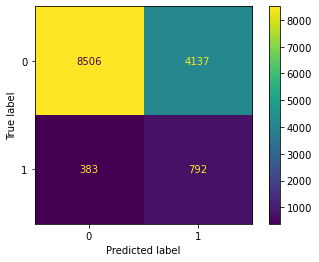

In [63]:
plot_confusion_matrix(cv_90_ada_pipe, test_token_docs, y_test)

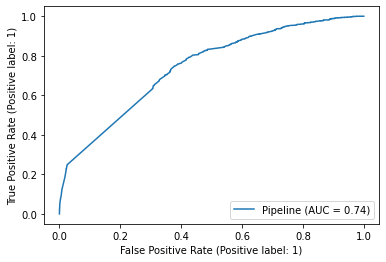

In [64]:
plot_roc_curve(cv_90_ada_pipe, test_token_docs, y_test)

In [66]:
y_hat_6 = cv_90_ada_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_6, y_true = y_test))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     12643
           1       0.16      0.67      0.26      1175

    accuracy                           0.67     13818
   macro avg       0.56      0.67      0.52     13818
weighted avg       0.89      0.67      0.74     13818



## NLP Cleanup for Words Only (No # or @)

In [19]:
def doc_preparer_2(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [20]:
token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_train]
test_token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_test]

## TFIDF / ADA/ Different classes

In [22]:
class_balances = ['auto', 0.75, 0.9]

For Class: auto
Training Score = 0.8836822203325433
Cross-Val Scores = [0.87996382 0.87434413 0.88429528 0.87606296 0.88402388]
Testing Score = 0.8876103632942539
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     12643
           1       0.39      0.57      0.46      1175

    accuracy                           0.89     13818
   macro avg       0.67      0.74      0.70     13818
weighted avg       0.91      0.89      0.90     13818

---------------------------------------------------------
For Class: 0.75
Training Score = 0.8858352481409781
Cross-Val Scores = [0.88720036 0.88402388 0.88908992 0.88809481 0.88818527]
Testing Score = 0.8894919669995658
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     12643
           1       0.39      0.56      0.46      1175

    accuracy                           0.89     13818
   macro avg       0.68      0.74      0.70     13818
weighted avg     

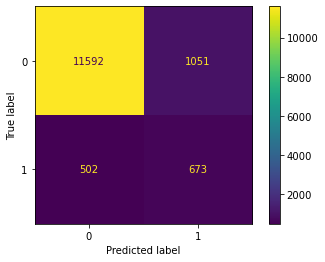

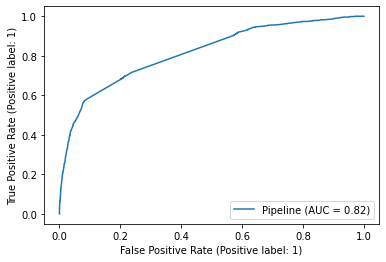

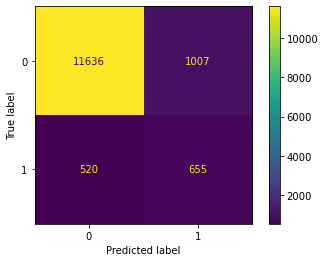

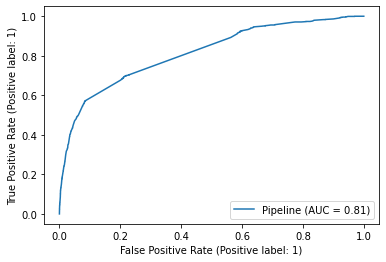

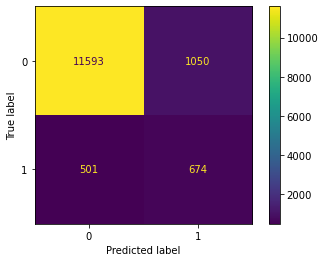

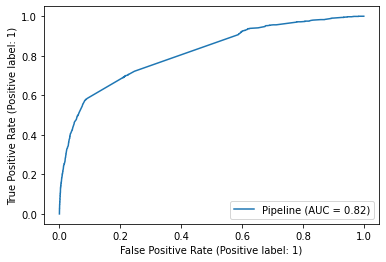

In [23]:
for balance in class_balances:
    tfidf_ada_pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = balance)),
    ('ada', AdaBoostClassifier())
])
    tfidf_ada_pipe_2.fit(token_docs_2, y_train)
    print(f"For Class: {balance}")
    print(f"Training Score = {tfidf_ada_pipe_2.score(token_docs_2, y_train)}")
    print(f"Cross-Val Scores = {cross_val_score(tfidf_ada_pipe_2, token_docs_2, y_train, cv = 5)}")
    print(f"Testing Score = {tfidf_ada_pipe_2.score(test_token_docs_2, y_test)}")
    plot_confusion_matrix(tfidf_ada_pipe_2, test_token_docs_2, y_test)
    plot_roc_curve(tfidf_ada_pipe_2, test_token_docs_2, y_test)
    y_hat_6 = tfidf_ada_pipe_2.predict(test_token_docs_2)
    print(classification_report(y_pred = y_hat_6, y_true = y_test))
    print("---------------------------------------------------------")

## Count Vectorizer / ADA /Different Classes

For Class: auto
Training Score = 0.6643447739320801
Cross-Val Scores = [0.65635459 0.68310114 0.65686629 0.66482721 0.67884929]
Testing Score = 0.6640613692285425
              precision    recall  f1-score   support

           0       0.96      0.66      0.78     12643
           1       0.16      0.70      0.26      1175

    accuracy                           0.66     13818
   macro avg       0.56      0.68      0.52     13818
weighted avg       0.89      0.66      0.74     13818

---------------------------------------------------------
For Class: 0.75
Training Score = 0.681170957645058
Cross-Val Scores = [0.67725011 0.68129184 0.67812557 0.67115976 0.68074905]
Testing Score = 0.6836011000144738
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     12643
           1       0.16      0.66      0.26      1175

    accuracy                           0.68     13818
   macro avg       0.56      0.67      0.53     13818
weighted avg      

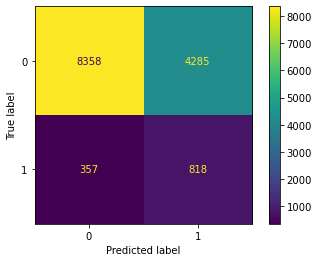

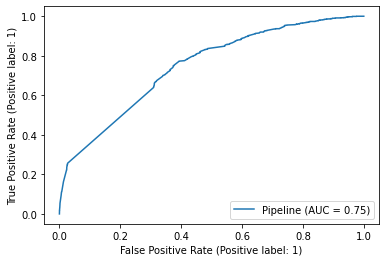

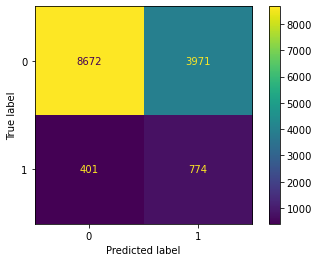

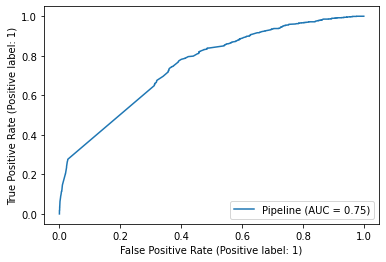

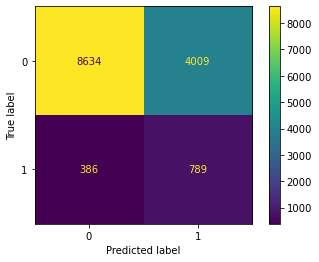

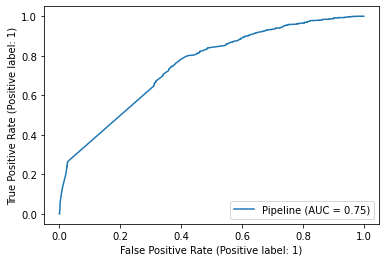

In [24]:
for balance in class_balances:
    cv_ada_pipe_2 = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = balance)),
    ('ada', AdaBoostClassifier())
])
    cv_ada_pipe_2.fit(token_docs_2, y_train)
    print(f"For Class: {balance}")
    print(f"Training Score = {cv_ada_pipe_2.score(token_docs_2, y_train)}")
    print(f"Cross-Val Scores = {cross_val_score(cv_ada_pipe_2, token_docs_2, y_train, cv = 5)}")
    print(f"Testing Score = {cv_ada_pipe_2.score(test_token_docs_2, y_test)}")
    plot_confusion_matrix(cv_ada_pipe_2, test_token_docs_2, y_test)
    plot_roc_curve(cv_ada_pipe_2, test_token_docs_2, y_test)
    y_hat_7 = cv_ada_pipe_2.predict(test_token_docs_2)
    print(classification_report(y_pred = y_hat_7, y_true = y_test))
    print("---------------------------------------------------------")